In [1]:
# load_Johnson2013_python3

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec

import numpy as np

import netCDF4 as nc
from netCDF4 import Dataset

from scipy.interpolate import griddata

import os
import fnmatch
import datetime
#import logging

import pyfesom2 as pf

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
# settings
obspath = '/home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/'
varChl = 'chlorophyll'

savepath = obspath

process_all = False

In [4]:
def mygrid(m,grid=False):
    '''
    Draw cartopy natural earth feature to axis m
    '''
    #m.coastlines(resolution='110m', color='black', linewidth=1)
    land_poly = cfeature.NaturalEarthFeature('physical', 'land', '110m',edgecolor='k',facecolor=cfeature.COLORS['land'])
    m.add_feature(land_poly)
    
    if grid:
        g1 = m.gridlines(draw_labels = True)
        g1.xlabels_top = False
        g1.xlabel_style = {'size': 16, 'color': 'gray'}
        g1.ylabel_style = {'size': 16, 'color': 'gray'}

In [17]:
def read_Johnson(ncpath):
    '''
    Read in NCfile from Johnson et al (2013) and process timestamp information
    
    return nc_chl, nc_lat, nc_lon, dtime #,nc_timestamp
    '''

    print('Reading {0}'.format(ncpath))
    
    f      = Dataset(ncpath, 'r')
    #f.variables
    # 'chlorophyll', 'latitude', 'longitude', 'time'

    nc_chl = f.variables[varChl][:] # units: mg/m^3

    nc_lat = f.variables['latitude'][:] # units: degrees_north
    nc_lon = f.variables['longitude'][:] # units: degrees_east

    #print('NC chl data shape {0}'.format(np.shape(nc_chl)))
    #print(np.shape(nc_lat))

    ### extract time information
    nc_time_var = f.variables['time']
    date_units = nc_time_var.getncattr('units') # units: days since 1990-01-01 00:00:00.0

    dtime = nc.num2date(nc_time_var[:],date_units,calendar='gregorian', only_use_cftime_datetimes=False)
    #nc_timestamp = dtime[0].strftime('Data from %Y/%m/%d at %H:%Mh')
    #print(nc_timestamp)

    #londic, latdic = np.meshgrid(nc_lon,nc_lat)

    return nc_chl, nc_lat, nc_lon, dtime[0] #,nc_timestamp

In [6]:
testfile1 = obspath+ 'S20100012010031.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc'
!ncdump -h $testfile1

netcdf S20100012010031.L3m_MO_SO_Chl_9km.Johnson_SO_Chl {
dimensions:
	time = 1 ;
	latitude = 720 ;
	longitude = 4320 ;
variables:
	float chlorophyll(time, latitude, longitude) ;
		chlorophyll:_FillValue = -999.f ;
		chlorophyll:long_name = "Southern Ocean Regional Monthly SeaWiFS Chlorophyll Concentration, Johnson et al 2013" ;
		chlorophyll:units = "mg/m^3" ;
	double latitude(latitude) ;
		latitude:standard_name = "latitude" ;
		latitude:long_name = "latitude" ;
		latitude:units = "degrees_north" ;
		latitude:axis = "Y" ;
	double longitude(longitude) ;
		longitude:standard_name = "longitude" ;
		longitude:long_name = "longitude" ;
		longitude:units = "degrees_east" ;
		longitude:axis = "X" ;
	char originalFileAttributes ;
		originalFileAttributes:input_files = "S20100012010031.L3m_MO_RRS_Rrs" ;
		originalFileAttributes:sensor_name = "SeaWiFS" ;
		originalFileAttributes:sensor = "Sea-viewing Wide Field-of-view Sensor (SeaWiFS)" ;
		originalFileAttributes:title = "SeaWiFS Level-3 Stand

In [12]:
# read in all Johnson files
verbose = False

# start searching files
DEFAULT_FILE_FILTER = '*9km.Johnson_SO_Chl.nc'

nc_files=[]
nc_paths=[]
for root, _, filenames in os.walk(obspath):
    for filename in fnmatch.filter(filenames, DEFAULT_FILE_FILTER):
        nc_files.append(os.path.join(root, filename))
        nc_paths.append(root)
        if verbose:
            print('Found: '+os.path.join(root, filename))
        
        
print('\nFound {0} ncfiles which match "{1}"'.format(len(nc_files),DEFAULT_FILE_FILTER))



Found 157 ncfiles which match "*9km.Johnson_SO_Chl.nc"


In [15]:
process_all = True
if process_all:
    
    chl_all = []
    timestamp_all = []
    
    for i in range(len(nc_files)):
        input_file = nc_files[i]
        input_path = nc_paths[i]

        print('\n*** Processing:\n*** '+input_path)

        nc_chl, nc_lat, nc_lon, nc_timestamp = read_Johnson(input_file)

        chl_all.append(nc_chl)
        timestamp_all.append(nc_timestamp)

        


*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S20101822010212.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S20101212010151.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S19990011999031.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S19991521999181.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/moz

NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S20002452000274.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S20083362008366.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S19980601998090.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S19992441999273.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_South

NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S19992131999243.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S20042452004274.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S19990911999120.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S19993351999365.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_South

NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S19973051997334.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S20041532004182.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S20070322007059.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S20000012000031.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_South

NC chl data shape (1, 720, 4320)

*** Processing:
*** /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S19981211998151.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)


# Diagnostics

In [16]:
#print(timestamp_all)
print('Johnson (2013) data range from {0} to {1}\nnumber of timesteps: {2}'.format(
    np.nanmin(timestamp_all),
    np.nanmax(timestamp_all),
    len(timestamp_all)))

Johnson (2013) data range from 1997-09-01 00:00:00 to 2010-12-01 00:00:00
number of timesteps: 157


In [18]:
# check input shape
print(np.shape(chl_all))

(157, 1, 720, 4320)


In [19]:
# remove chlorophyll:_FillValue = -999.f
chl_aux = np.squeeze(chl_all)
print(np.shape(chl_aux))

chl_aux[chl_aux < 0] = np.nan

(157, 720, 4320)


# Mean over years

In [20]:
# calculate mean over years
chl_mean = np.nanmean(chl_aux,axis=0)
print(np.shape(chl_mean))

(720, 4320)


<ipython-input-20-90cb221fa112>:2: RuntimeWarning: Mean of empty slice
  chl_mean = np.nanmean(chl_aux,axis=0)


In [21]:
# check values
print(np.nanmin(chl_mean), np.nanmax(chl_mean),np.nanmean(chl_mean))

0.038814235 23.92979 0.6262606


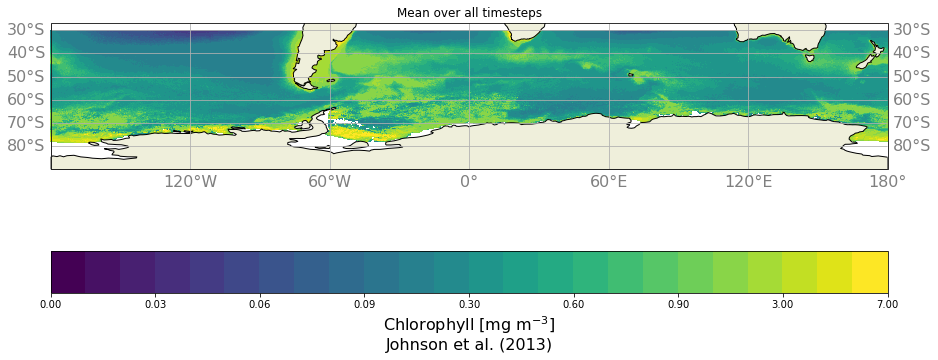

In [24]:
fig, axes = plt.subplots(1,1, 
             subplot_kw=dict(projection=ccrs.PlateCarree()),
             gridspec_kw={'hspace': 0.01, 'wspace': 0.1},
             figsize=(15,15))

unit_nc_chl = 'Chlorophyll [mg m$^{-3}$]'

levels = np.array([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
                   0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,
                   1,2,3,4,5,7])
ticks = [0,0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,1,3,5,7]
ticks_label = ['0','0.01','0.03','0.05','0.07','0.1','0.3','0.5','0.7','1','3','5','7']


m1 = axes
londic, latdic = np.meshgrid(nc_lon,nc_lat)
f = m1.pcolormesh(londic, latdic, chl_mean, 
    transform = ccrs.PlateCarree(),
    norm=colors.BoundaryNorm(boundaries=levels, ncolors=256),
    #norm=colors.LogNorm(vmin=np.nanmin(nc_chl),vmax=np.nanmax(nc_chl)),
    cmap='viridis')
mygrid(m1,grid=True)
m1.set_title('Mean over all timesteps')


cbar = fig.colorbar(f,ax = axes, 
                    #location = 'bottom',
                    orientation = 'horizontal',
                    fraction=0.1, pad=0.1) 
cbar.set_label(unit_nc_chl+'\nJohnson et al. (2013)', fontsize=16)

plt.savefig(savepath+'Johnson2013_MEAN_Chl.png', dpi=300, bbox_inches='tight')

# Interpolate to regular 1x1

In [28]:
ilat         = np.arange(-89.5,-29.5,1.)
ilon         = np.arange(-179.5,180.,1.)
ilatdic, ilondic = np.meshgrid(ilat, ilon)

print(ilat)

[-89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 -81.5 -80.5 -79.5 -78.5
 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5
 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5
 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5
 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5]


In [29]:
chl_mean_interp = griddata((londic.ravel(), latdic.ravel()), chl_mean.ravel(), (ilondic,ilatdic), method='nearest')
chl_mean_interp = np.ma.filled(chl_mean_interp, np.nan)

# apply sea mask to Takashi as in FESOM ----------------------------------------------------------------------------------
# assumption: there is no ocean where value in FESOM == 0
#CO2ftakashi_ma = np.copy(CO2ftakashi)
#CO2ftakashi_ma[np.isnan(CO2ffesom)] = np.nan

# check interpolation results

In [32]:
print(np.shape(chl_mean_interp))

(360, 60)


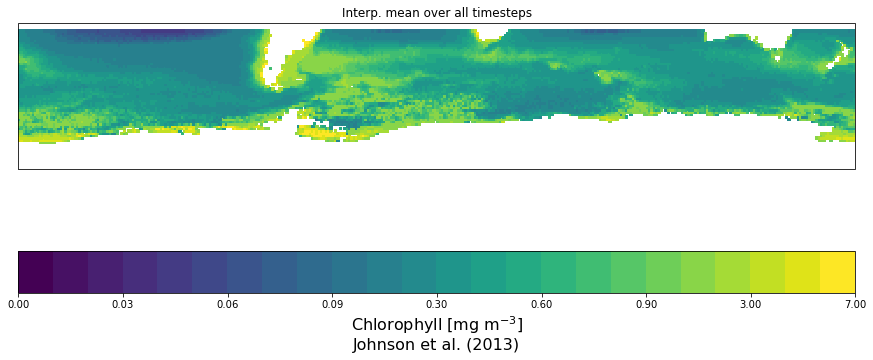

In [34]:
fig, axes = plt.subplots(1,1, 
             subplot_kw=dict(projection=ccrs.PlateCarree()),
             gridspec_kw={'hspace': 0.01, 'wspace': 0.1},
             figsize=(15,15))

unit_nc_chl = 'Chlorophyll [mg m$^{-3}$]'

levels = np.array([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
                   0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,
                   1,2,3,4,5,7])
ticks = [0,0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,1,3,5,7]
ticks_label = ['0','0.01','0.03','0.05','0.07','0.1','0.3','0.5','0.7','1','3','5','7']


m1 = axes
f = m1.pcolormesh(ilondic, ilatdic, chl_mean_interp, 
    transform = ccrs.PlateCarree(),
    norm=colors.BoundaryNorm(boundaries=levels, ncolors=256),
    #norm=colors.LogNorm(vmin=np.nanmin(nc_chl),vmax=np.nanmax(nc_chl)),
    cmap='viridis')

mygrid(m1,grid=True)
m1.set_title('Interp. mean over all timesteps')


cbar = fig.colorbar(f,ax = axes, 
                    #location = 'bottom',
                    orientation = 'horizontal',
                    fraction=0.1, pad=0.1) 
cbar.set_label(unit_nc_chl+'\nJohnson et al. (2013)', fontsize=16)

#plt.savefig(savepath+'Johnson2013_MEAN_Interp_Chl.png', dpi=300, bbox_inches='tight')

# Save data to .npy file

In [35]:
np.save(savepath+'Johnson2013_MEAN_Chl_mg_m3.npy',chl_mean)
np.save(savepath+'Johnson2013_MEAN_1x1_Chl_mg_m3.npy',chl_mean_interp)

np.save(savepath+'Johnson2013_timestamps.npy',timestamp_all)

# fill masked array
nc_lat_filled = np.ma.filled(nc_lat, np.nan)
nc_lon_filled = np.ma.filled(nc_lon, np.nan)

np.save(savepath+'Johnson2013_lat.npy',nc_lat_filled)
np.save(savepath+'Johnson2013_lon.npy',nc_lon_filled)

# interpolated grid see above!

# Test processing on random input files

In [143]:
if not process_all:
    
    # load
    testfile1 = obspath+ 'S20100012010031.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc'
    testfile2 = obspath + 'S20010912001120.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc'
    testfile3 = obspath + 'S19980011998031.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc'
    
    nc_chl1, nc_lat1, nc_lon1, nc_timestamp1 = read_Johnson(testfile1)
    nc_chl2, nc_lat2, nc_lon2, nc_timestamp2 = read_Johnson(testfile2)
    nc_chl3, nc_lat3, nc_lon3, nc_timestamp3 = read_Johnson(testfile3)
    
    
    

Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S20100012010031.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S20010912001120.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)
Reading /home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/S19980011998031.L3m_MO_SO_Chl_9km.Johnson_SO_Chl.nc
NC chl data shape (1, 720, 4320)


/home/ollie/mozeisin/.conda/envs/pyfesom2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


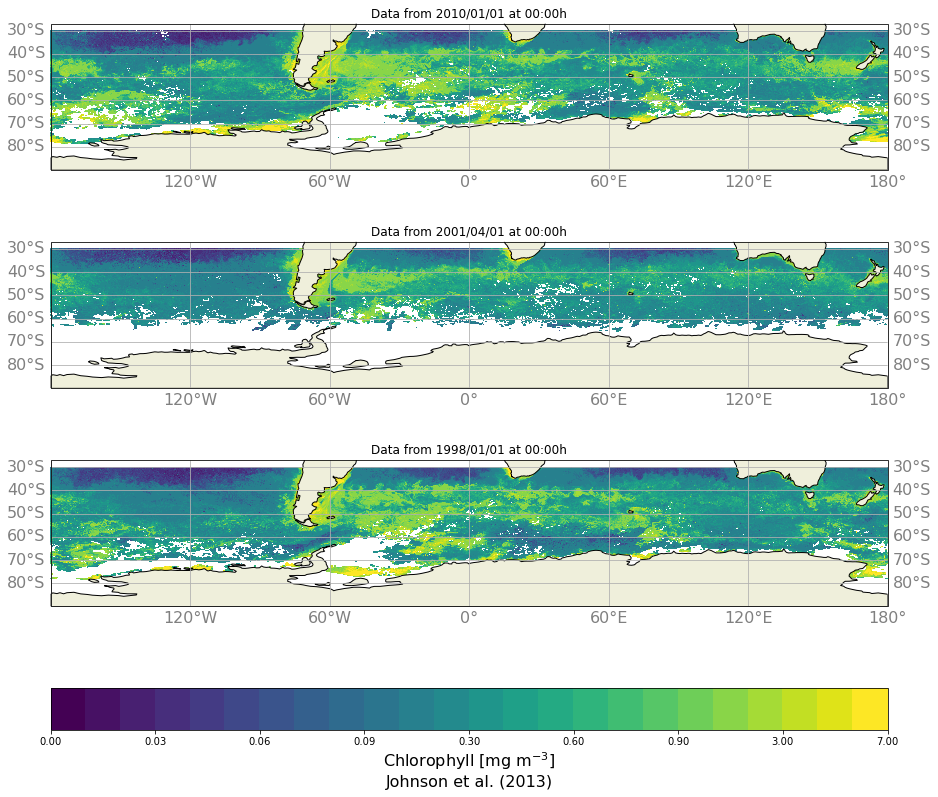

In [145]:
if not process_all:
    fig, axes = plt.subplots(3,1, 
             subplot_kw=dict(projection=ccrs.PlateCarree()),
             gridspec_kw={'hspace': 0.01, 'wspace': 0.1},
             figsize=(15,15))
    
    levels = np.array([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
                       0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,
                       1,2,3,4,5,7])
    ticks = [0,0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,1,3,5,7]
    ticks_label = ['0','0.01','0.03','0.05','0.07','0.1','0.3','0.5','0.7','1','3','5','7']


    m1 = axes[0] 
    londic, latdic = np.meshgrid(nc_lon1,nc_lat1)
    f = m1.pcolormesh(londic, latdic, nc_chl1[0,:,:], 
        transform = ccrs.PlateCarree(),
        norm=colors.BoundaryNorm(boundaries=levels, ncolors=256),
        #norm=colors.LogNorm(vmin=np.nanmin(nc_chl),vmax=np.nanmax(nc_chl)),
        cmap='viridis')
    mygrid(m1,grid=True)
    m1.set_title(nc_timestamp1.strftime('Data from %Y/%m/%d at %H:%Mh'))
    
    m2 = axes[1]
    londic, latdic = np.meshgrid(nc_lon2,nc_lat2)
    f = m2.pcolormesh(londic, latdic, nc_chl2[0,:,:], 
        transform = ccrs.PlateCarree(),
        norm=colors.BoundaryNorm(boundaries=levels, ncolors=256),
        #norm=colors.LogNorm(vmin=np.nanmin(nc_chl),vmax=np.nanmax(nc_chl)),
        cmap='viridis')
    mygrid(m2,grid=True)
    m2.set_title(nc_timestamp2.strftime('Data from %Y/%m/%d at %H:%Mh'))
    
    m3 = axes[2]
    londic, latdic = np.meshgrid(nc_lon3,nc_lat3)
    f = plt.pcolormesh(londic, latdic, nc_chl3[0,:,:], 
        transform = ccrs.PlateCarree(),
        norm=colors.BoundaryNorm(boundaries=levels, ncolors=256),
        #norm=colors.LogNorm(vmin=np.nanmin(nc_chl),vmax=np.nanmax(nc_chl)),
        cmap='viridis')
    mygrid(m3,grid=True)
    m3.set_title(nc_timestamp3.strftime('Data from %Y/%m/%d at %H:%Mh'))
    
    cbar = fig.colorbar(f,ax = axes[:3], 
                        location = 'bottom',
                        #orientation = 'horizontal',
                        fraction=0.1, pad=0.1) 
    cbar.set_label(unit_nc_chl+'\nJohnson et al. (2013)', fontsize=16)